<a href="https://colab.research.google.com/github/JingwenLuo7/Machine-Learning-in-Bioinformatics-S25/blob/main/Project02_geyser/Geyser-EM-etu_en_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [62]:
from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/ML/Project02/"

params_path="/content/drive/MyDrive/ML/Project02/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Students names and ID: Zhixin Mao 5598473， Jingwen Luo
Students group: 18

# A. EM and the Old Faithful geyser

![Old_Faithful.jpg](attachment:Old_Faithful.jpg)

The duration of the eruptions varies in time as well as the delay between two consecutive eruptions. Our hypothesis is that these flares actually follow two distinct distributions that we will try to identify. We will thus use unsupervised learning of a variable in order to detect to which distribution each flare belongs.


Size of the data (272, 2)


Text(0, 0.5, 'Waiting time between eruptions')

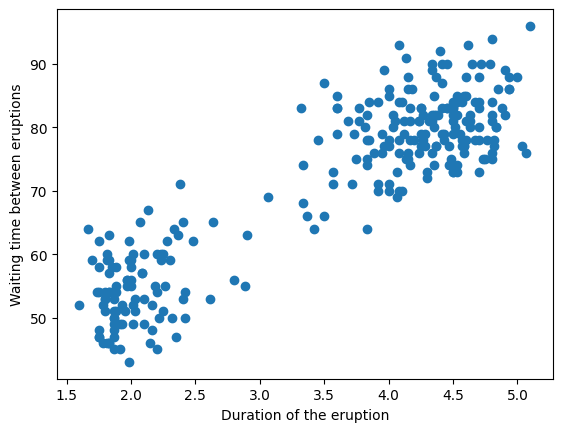

In [6]:
# Loading dataset:

data = pkl.load(open(filepath+'faithful.pkl', 'rb'))
X = data["X"]

print("Size of the data", X.shape)
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.xlabel("Duration of the eruption")
plt.ylabel("Waiting time between eruptions")
# We can easily identify the two distributions, this is schoolbook example
# ... The goal will be to do so automatically


## A.1 Modeling

Following the previous visualisation, we choose to model the data using two latent distributions which are normal/gaussian distributions. We will have to determine their parameters.
The likelihood of a normal distribution of dimension $N$ for an observation $\mathbf x \in \mathbb R^{N}$ is the following:

$$p(\mathbf x | \mu, \Sigma) = \frac{1}{(2 \pi)^{N / 2}|\Sigma|^{1 / 2}} e^{-\frac{1}{2}(\mathbf x-\mu) \Sigma^{-1}(\mathbf x-\mu)^{\top}}, \qquad  \mu \in \mathbb R ^N, \Sigma \in \mathbb R ^{N\times N}$$

The parameters of the normal distribution are:
- $\mu \in \mathbb{R}^N$ the mean vector
- $\Sigma \in \mathbb{R}^{N\times N}$ the covariance matrix.

$|\Sigma|$ is the determinant of the matrix $\Sigma$.

### Checking dimensions of the variables

Check rapidly on a draft paper that $(x-\mu) \Sigma^{-1}(\mathbf x-\mu)^{\top}$ is indeed a scalar value in $\mathbb{R}$. It is a good way to avoid implementation errors later on.

### Writing the likelihood function

Write the code for `normal_2d`:`array(float) x array(float) x array(float) -> float` which takes as arguments `x, mu, Sig` and that returns the likelihood.

Note: You will look up the numpy functions that compute the determinant and the inverse of a matrice


In [7]:
def normal_2d(x, mu, Sig):
    N = x.shape[0]
    diff = x - mu
    det = np.linalg.det(Sig)
    inv = np.linalg.inv(Sig)
    norm_const = 1.0 / (np.power(2 * np.pi, N / 2) * np.sqrt(det))
    exponent = -0.5 * np.dot(np.dot(diff.T, inv), diff)
    return norm_const * np.exp(exponent)

In [8]:
mu  = np.array([1.,2])
Sig = np.array([[3., 0.],[0., 3.]])

x = np.array([1.,2])
print(normal_2d(x, mu, Sig)) # 0.053051647697298435
x = np.array([0,0])
print(normal_2d(x, mu, Sig)) # 0.023056151047594564

0.053051647697298435
0.023056151047594564


### Validating former results

Beyond the numbers obtained, does the order of the two probabilities seem valid? why?

### Visualizing the contour lines of the gaussian

Visualizing contour lines on a 2D continuous distribution implies that we work in 3D. The following function gives the code to perform this operation (you do not have to add any code here).

In [9]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [10]:
def plot_norm_2D(mu, Sig, bounds_min = np.array([-5, -5]), bounds_max = np.array([5, 5])):
    ngrid = 30
    x = np.linspace(bounds_min[0], bounds_max[0], ngrid)
    y = np.linspace(bounds_min[1], bounds_max[1], ngrid)
    X,Y = np.meshgrid(x,y)
    Z = np.array([normal_2d(np.array([x,y]), mu, Sig)
                  for x,y in zip(X.flatten(), Y.flatten())]).reshape(ngrid, ngrid)
    fig = plt.gcf() # getting the current plot
    ax = fig.gca()
    ax.contour(X,Y,Z)


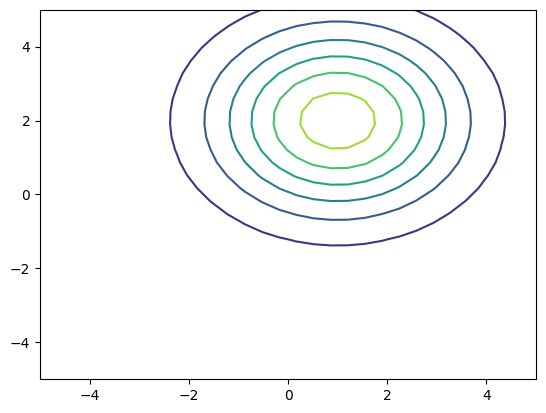

In [11]:
# test on the distribution specified above
plt.figure()
plot_norm_2D(mu, Sig)

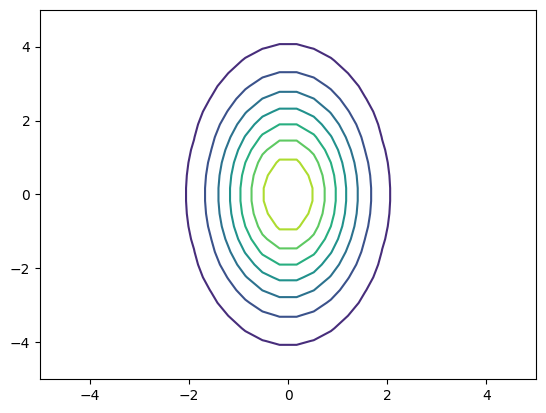

In [12]:
# other test with two different variance values on the two axis
mu2  = np.array([0.,0.])
Sig2 = np.array([[1., 0.],[0., 4.]])
plt.figure()
plot_norm_2D(mu2, Sig2)

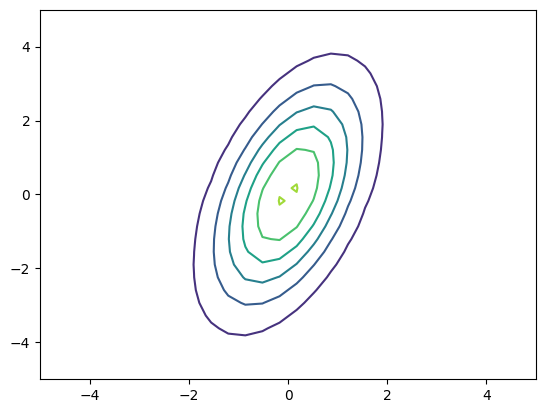

In [13]:
# Last test with a positive covariance between the two dimension
# Note: be aware that the covariance matrix has to be symetric !!!
mu3  = np.array([0.,0.])
Sig3 = np.array([[1., 1.],[1., 4.]])
plt.figure()
plot_norm_2D(mu3, Sig3)

### Constructing by hand a gaussian that roughly fits our data

We only consider the upper right corner.

Estimating the mean: (4.25, 80) after inspecting the first figure.  

Estimating standard deviation $\sigma_1$ on first axis : ??? (Thumbrule : 2/3 of the data points should fits within $[\mu-\sigma_1; \mu+\sigma_1]$)

Estimating standard deviation on second axis 2 : ??? (Thumbrule : 2/3 of the data points should fits within $[\mu-\sigma_2; \mu+\sigma_2]$)

Estimating covariance $\rho$: ???

Once the covariance matrix has been estimated you should obtain:
![manual_gauss_2d.png](attachment:manual_gauss_2d.png)

**Note:** Be careful of not mixing up the standard deviation $\sigma$ and the variance $\sigma^2$.

sd for first axis:	 0.4096760458743778
sd for second axis:	 5.977088227010656
covariance:	 0


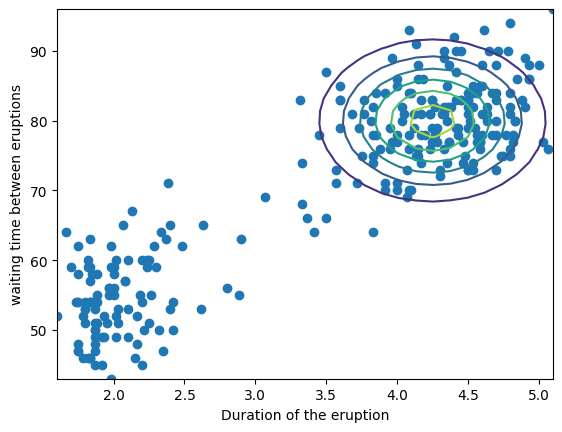

In [39]:
# your code her
mu4  = np.array([4.25, 80])

upper_cluster_indices = (X[:, 0] > 3) & (X[:, 1] > 30)
X_upper = X[upper_cluster_indices]

sigma1 = np.std(X_upper[:, 0])
sigma2 = np.std(X_upper[:, 1])
rho = 0
Sig4 = np.array([
    [sigma1**2, rho * sigma1 * sigma2],
    [rho * sigma1 * sigma2, sigma2**2]
])

print("sd for first axis:\t",sigma1)
print("sd for second axis:\t",sigma2)
print("covariance:\t",rho)

plt.figure()
# Drawing the point
plt.scatter(X[:,0], X[:,1])
plt.xlabel("Duration of the eruption")
plt.ylabel("waiting time between eruptions")
plot_norm_2D(mu4, Sig4, X.min(0), X.max(0) )
plt.savefig('manual_gauss_2d.png')

## A.2 Automated learning

Now let's stop testing by hand and try an automatic approach with the following properties:
* it is robust to noisy data
* it can be extended to multi-dimensional data that are difficult to display

We will use an EM approach and we will use the following notations.

Let $\Theta$ be the parameters of our two-class normal modeling:

$$\Theta = \{(\pi_0 \in \mathbb R, \mu_0 \in \mathbb{R}^2, \Sigma_0\in \mathbb{R}^{2\times 2}), (\pi_1, \mu_1, \Sigma_1)\}$$

where $\pi$ denotes the prior probabilities of the two classes.

For simplicity, we propose to store all $\pi$ in a single data structure, all $\mu$ in a single data structure and all $\Sigma$ in a structure so that we can easily increase or decrease the number of classes to be found in the future.

### EM : Step 0, initialisation

$\pi = [0.5, 0.5]$ is the most neutral and coherent initialization with respect to the data

For $\mu$, a classical strategy consists in starting from the mean of the cloud and adding $1$ on the dimensions for $\mu_1$ and subtracting $1$ on all dimensions for $\mu_2$.

For $\Sigma$, we propose to start from the variance matrix of the whole cloud for both models. We propose to initialize a 3D matrix in order to access the matrices of the models by doing `Sig[0]` and `Sig[1]`

The method `init` takes as argument `X` and returns `pi`, `mu` and `Sig`.

**Note:** If you want to implement a more generic initialization, you have to take as additional argument the number of classes to predict (and possibly other things).

In [40]:
def init(X):
    pi = np.array([0.5, 0.5]) # most reasonnable choice and in agreement with the dataset
    pi = np.array([0.5, 0.5])  # neutral prior

    # Compute global mean
    mean = X.mean(axis=0)  # shape: (2,)

    # Initialize mus: one above, one below
    mu = np.array([mean + 1, mean - 1])

    # Covariance matrix of the dataset
    cov = np.cov(X.T)  # shape: (2, 2)

    # Repeat same covariance matrix for both clusters
    Sig = np.array([cov, cov])  # shape: (2, 2, 2)
    return pi, mu, Sig

pi, mu, Sig = init(X)
print(pi,"\n", mu,"\n", Sig)
# Check:
#[0.5 0.5]
# [[ 4.48778309 71.89705882]
# [ 2.48778309 69.89705882]]
# [[[  1.30272833  13.97780785]
#  [ 13.97780785 184.82331235]]
#
# [[  1.30272833  13.97780785]
#  [ 13.97780785 184.82331235]]]

[0.5 0.5] 
 [[ 4.48778309 71.89705882]
 [ 2.48778309 69.89705882]] 
 [[[  1.30272833  13.97780785]
  [ 13.97780785 184.82331235]]

 [[  1.30272833  13.97780785]
  [ 13.97780785 184.82331235]]]


###  EM : the E step

We will now write the E step of the EM algorithm, which will allow us to estimate the parameters of the mixture of two-dimensional normal distribution.

As seen in the course, let $Z$ be a random variable indicating which class/bidimensional normal law has generated the pair of data $\mathbf x \in \mathbb R^2$

Let $\Theta^t = \{\pi^t, \mu^t, \Sigma^t\}$ be the parameters at iteration $t$.

For each observation $\mathbf x$, we define $Q_i^{t+1}(0) = P(Z = 0|\mathbf x, \Theta^t)$, the probability of being from class $0$ for  an observation $\mathbf x$ given current parameters $\Theta^t$.

Applying bayes rule we can compute the probability for each class.
    $$Q_i^{t+1}(0) = \frac{p(\mathbf x | \mu_0, \Sigma_0) \pi_0}{\sum_{i=0}^1 p(\mathbf x | \mu_i, \Sigma_i) \pi_i},\qquad  Q_i^{t+1}(1) = \frac{p(\mathbf x | \mu_1, \Sigma_1) \pi_1}{\sum_{i=0}^1 p(\mathbf x | \mu_i, \Sigma_i) \pi_i}$$
    
Write the function `Q_i: np.array x np.array x np.array x np.array -> np.array` which takes as argument `X, pi, mu, Sig` and that returns the table of all $Q_i$ values.

Be carefull, `X` is the matrix containing all data points, `pi` is the vector of prior probabilities, `mu` and `Sig` are matrices contening the parameters for the two classes.  

In [41]:
from scipy.stats import multivariate_normal

def Q_i(X, pi, mu, Sig):
    n_classes = len(pi)
    n_points = X.shape[0]

    q = np.zeros((n_classes, n_points))  # shape: (2, n)

    # Loop over classes (0 and 1)
    for i in range(n_classes):
        # Compute the PDF of the multivariate normal for all points
        pdf_vals = multivariate_normal.pdf(X, mean=mu[i], cov=Sig[i])

        # Multiply by class prior
        q[i] = pi[i] * pdf_vals

    # Normalize over classes (axis=0)
    q /= q.sum(axis=0)

    return q

q = Q_i(X, pi, mu, Sig)

print(q[:,:5]) # q for the 5 first data points
# [[0.02459605 0.03668168 0.05226123 0.01630238 0.49795917]
# [0.97540395 0.96331832 0.94773877 0.98369762 0.50204083]]

[[0.02459605 0.03668168 0.05226123 0.01630238 0.49795917]
 [0.97540395 0.96331832 0.94773877 0.98369762 0.50204083]]


### EM : the M Step
#### (demonstration of the update formulas is given at the end)

Maximising the likelihood is a good opportunity to recall how the parameters for the bidimensional normal distribution are computed. We integrate here the reweighting from the $q$ values.

Thus:
$$ \mu_0 = \frac{\sum_i Q_i^{t+1}(0) \cdot \mathbf{x_i}}{\sum_i Q_i^{t+1}(0)}, \qquad \mu_1 = \frac{\sum_i Q_i^{t+1}(1) \cdot  \mathbf{x_i}}{\sum_i Q_i^{t+1}(1)} $$

$$ \Sigma_0 = \frac{\sum_i Q_i^{t+1}(0)\cdot  (\mathbf{x_i}-\mu_0)^T (\mathbf{x_i}-\mu_0) }{\sum_i Q_i^{t+1}(0)}, \qquad \Sigma_1 = \frac{\sum_i Q_i^{t+1}(1)\cdot  (\mathbf{x_i}-\mu_1)^T (\mathbf{x_i}-\mu_1)}{\sum_i Q_i^{t+1}(1)} $$

Take some time to draw the matrices shapes to verify the dimensions for $\Sigma$


The prior probabilities correspond to the ratio of the probability masses $Q$:
$$ \pi_0 = \frac{\sum_i Q_i^{t+1}(0) }{\sum_i Q_i^{t+1}(0) + Q_i^{t+1}(1) }, \qquad \pi_1 = \frac{\sum_i Q_i^{t+1}(1) }{\sum_i Q_i^{t+1}(0) +  Q_i^{t+1}(1)} $$

Write the function
`update_param: np.array x np.array x np.array x np.array x np.array -> np.array x np.array x np.array`
that takes as argument `X`, `q`, `pi`, `mu`, `Sig` and return a new version of `pi`, `mu`, `Sig`

In [42]:
def update_param(X, q, pi, mu, Sig):
    n_classes, n_points = q.shape
    d = X.shape[1]  # dimension of the data
    N_k = q.sum(axis=1)  # shape: (2,)

    # Update priors
    pi_u = N_k / n_points

    # Update means
    mu_u = np.zeros((n_classes, d))
    for k in range(n_classes):
        mu_u[k] = (q[k][:, np.newaxis] * X).sum(axis=0) / N_k[k]

    # Update covariances
    Sig_u = np.zeros((n_classes, d, d))
    for k in range(n_classes):
        X_centered = X - mu_u[k]  # shape: (n, d)
        weighted_outer = q[k][:, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', X_centered, X_centered)
        Sig_u[k] = weighted_outer.sum(axis=0) / N_k[k]

    return pi_u, mu_u, Sig_u

pi_u, mu_u, Sig_u = update_param(X, q, pi, mu, Sig)


print(pi_u,"\n", mu_u,"\n", Sig_u)
# check:
# [0.51132321 0.48867679]
# [[ 3.88361418 71.3886521 ]
# [ 3.07360826 70.38268397]]
# [[[  1.04337668  12.40444673]
#  [ 12.40444673 162.96851264]]
#
# [[  1.22881404  15.10227603]
#  [ 15.10227603 205.78298546]]]

[0.51132321 0.48867679] 
 [[ 3.88361418 71.3886521 ]
 [ 3.07360826 70.38268397]] 
 [[[  1.04337668  12.40444673]
  [ 12.40444673 162.96851264]]

 [[  1.22881404  15.10227603]
  [ 15.10227603 205.78298546]]]


### EM Algorithm: the loop

Alternate iterations of the E and the M step until convergence. Convergence is assessed by verifying that the updated parameters at $t+1$ are very close to the previous ones. We can do the convergence test on `mu` which is quite stable by checking the sum of the absolute differences: $| \mu^{t+1}_1 - \mu^t_1 | + |\mu^{t+1}_2 - \mu^t_2|$. Alternatively, one can also use the relative increase in the likelihood of the data to assess convergence.

The `EM` method takes `X` as argument and returns `pi`, `mu` and `Sig`. `nIterMax` is a default parameter to avoid infinite loop. Generally, iterative EM algorithms are coded with for loops rather than while loops for reliability.

The `saveParam` parameter will be useful in the following questions: you do not need to worry about it now.

In [52]:
import os

def EM(X, nIterMax=100, saveParam=None, tol=1e-3):
    pi, mu, Sig = init(X)

    for iteration in range(nIterMax):
        # E-step: compute responsibilities
        q = Q_i(X, pi, mu, Sig)

        # Store old mu for convergence check
        mu_old = mu.copy()

        # M-step: update parameters
        pi, mu, Sig = update_param(X, q, pi, mu, Sig)

        # Convergence check on mu
        diff = np.abs(mu - mu_old).sum()
        if diff < tol:
            print(f"Converged at iteration {iteration}")
            break

    return pi, mu, Sig

pi, mu, Sig = EM(X)
print(pi,"\n", mu,"\n", Sig)



# Should converge in 22 iterations with a threshold at 1e-3 on absolute difference of the means
# [0.64411944 0.35588056]
# [[ 4.28967856 79.96831569]
# [ 2.0364072  54.47870502]]
# [[[ 0.16994739  0.94034165]
#  [ 0.94034165 36.04319866]]
#
# [[ 0.06918256  0.43532305]
#  [ 0.43532305 33.69834324]]]

Converged at iteration 22
[0.64412529 0.35587471] 
 [[ 4.28966596 79.96816344]
 [ 2.03639296 54.47856174]] 
 [[[ 0.16996337  0.94054489]
  [ 0.94054489 36.04548599]]

 [[ 0.06917125  0.43520499]
  [ 0.43520499 33.69753693]]]


### Displaying the results

A the end of the iterations you should get the following figure:

![res_EM.png](attachment:res_EM.png)

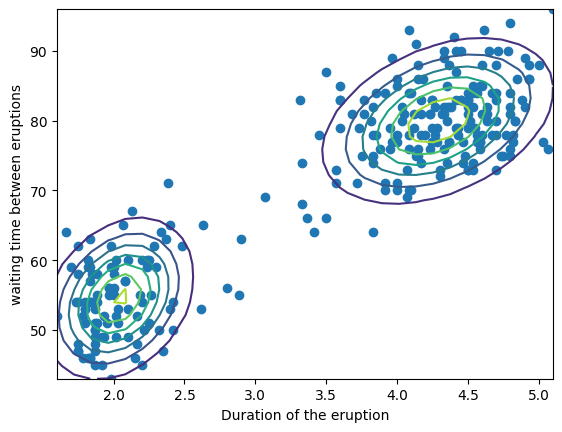

In [47]:
plt.figure()

plt.scatter(X[:,0], X[:,1])
plt.xlabel("Duration of the eruption")
plt.ylabel("waiting time between eruptions")
plot_norm_2D(mu[0], Sig[0], X.min(0), X.max(0) ) # plotting model 1
plot_norm_2D(mu[1], Sig[1], X.min(0), X.max(0) ) # plotting model 2
plt.savefig('res_EM.png')

## A-3 Small animated gif showing model convergence

The idea is to use the `saveParam` parameter of the EM method to save the parameters of the model at each iteration and to be able to trace all the figures corresponding to all the steps of the algorithm.

* you have to save the figures in a separate directory, otherwise your directory  will be a mess
* you have to give explicit file names to be able to retrieve figures in the right order
* you have to use pickle, because serialization is fantastic in this kind of case.


The idea is to call: `pi, mu, Sig = EM(X, saveParam="params/faithful")`

You will have to create the subdirectory `params` and then save the parameters in:
`params/faithful1.pkl`, `params/faithful2.pkl`, ...

In order to respect all the constraints, we suggest you to insert the following code in the EM method:
```python
import os # Adding the library before starting the method

     # detecting saving param
     if saveParam != None:     
          # creating subdirectory
          if not os.path.exists(saveParam[:saveParam.rfind('/')]):
                 os.makedirs(saveParam[:saveParam.rfind('/')])
          pkl.dump({'pi':pi_u, 'mu':mu_u, 'Sig': Sig_u},\
                    open(saveParam+str(i)+".pkl",'wb'))     # serializing
```

**Note:** all the code is given, you have to check that you are saving the right variables.

In [63]:
import os
import pickle

def EM(X, nIterMax=100, saveParam=None, tol=1e-3):
  pi, mu, Sig = init(X)

  for iteration in range(nIterMax):

    # E-step: compute responsibilities
    q = Q_i(X, pi, mu, Sig)

    # Store old mu for convergence check
    mu_old = mu.copy()

    # M-step: update parameters
    pi, mu, Sig = update_param(X, q, pi, mu, Sig)

    # detecting saving param
    if saveParam != None:
      # creating subdirectory
      if not os.path.exists(saveParam[:saveParam.rfind('/')]):
                 os.makedirs(saveParam[:saveParam.rfind('/')])
      pkl.dump({'pi':pi_u, 'mu':mu_u, 'Sig': Sig_u},\
                    open(saveParam+str(iteration)+".pkl",'wb'))     # serializing

    # Convergence check on mu
    diff = np.abs(mu - mu_old).sum()
    if diff < tol:
      print(f"Converged at iteration {iteration}")
      break

    return pi, mu, Sig

pi, mu, Sig = EM(X, saveParam="params/faithful")


You can then create the method to load parameters and create the animation using the code snippet below.

That does not always work out straight of the box... If it works you should obtain:
![old_faithful.gif](attachment:old_faithful.gif)

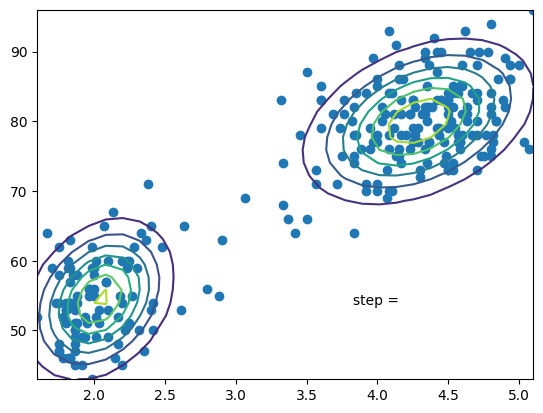

In [64]:
import matplotlib.animation as animation
import glob


def create_animation(X, params_path, fname):
    nbiter = len(glob.glob(params_path+"/*.pkl"))
    #print(nbiter)
    fig = plt.figure()
    plt.xlim(X[:,0].min()-(X[:,0].mean()*0.05), X[:,0].max()+(X[:,0].mean()*0.05))
    plt.ylim(X[:,1].min()-(X[:,1].mean()*0.05), X[:,1].max()+(X[:,1].mean()*0.05))
    plt.xlabel("Duration of the eruption")
    plt.ylabel("waiting time between eruptions")

    def animate(i):
        #print(i)
        data = pkl.load(open(params_path+"/"+fname+str(i)+".pkl","rb")) # loading a dictionnary of points
        plt.clf()
        ax  = fig.gca()
        ax.scatter(X[:,0], X[:,1])
        ax.text(X[:,0].max()*0.75, X[:,1].min()*1.25, 'step = ' )#+ str ( i ))
        for i in range(len(data['mu'])):
            plot_norm_2D(data['mu'][i], data['Sig'][i], X.min(0), X.max(0) ) # plot model i

        return ax

    ani = animation.FuncAnimation(fig, animate, frames = nbiter, interval=300, repeat=True )
    ani.save(params_path+'/animation.gif', bitrate=4000)


create_animation(X, "params", "faithful")


## A-4 Influence of initialisation parameters

EM is very often associated with non-convex likelihood functions. This means that there are multiples maxima and that a bad initialization can have disastrous consequences on the convergence of the algorithm.

Let's imagine a new initialization function where the initial averages are initialized in an unfavorable way, i.e. orthogonally to the natural separability of the data.

The data are really easy to separate and the code will continue to work... But we notice that convergence is much slower.

![old_faithful_bad.gif](attachment:old_faithful_bad.gif)

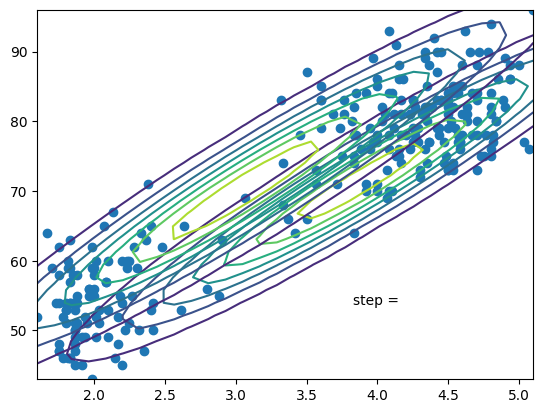

In [65]:
def init(X):
    pi = np.array([0.5, 0.5]) # in agreement with data, no prior

    mu1 = X.mean(0)+ [0.1,-15] # bad initialisation
    mu2 = X.mean(0)+ [-0.1,15]
    mu  = np.vstack((mu1, mu2))

    Sig = np.zeros((2, 2, 2))
    Sig[0,:,:] = np.cov(X.T)
    Sig[1,:,:] = np.cov(X.T)
    return pi, mu, Sig


# Short reminder about notebooks
# We just redefined the init function in this cell.
# EM call implies a call to init.
# Thus the new version of init give a new version of EM

pi, mu, Sig = EM(X, saveParam="params_bad/faithful")
create_animation(X, "params_bad", "faithful")

# B- Working with 4 classes

We can construct a new toy dataset where there are 4 classes to detect.  

Change your code to take this case into account.

![data_gauss.png](attachment:data_gauss.png)

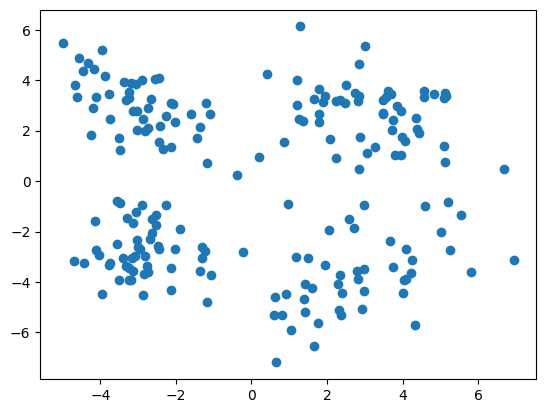

In [66]:
def generating_4_gaussians():
    n = 50 # nb points for each normal distribution

    Sig1 = np.array([[1, 0],[0, 1]])
    mu1  = np.array([-3, -3])
    Sig2 = np.array([[1.5, 0.5],[0.5, 1.5]])
    mu2  = np.array([3, -3])
    Sig3 = np.array([[1.2, -0.5],[-0.5, 1.2]])
    mu3  = np.array([-3, 3])
    Sig4 = np.array([[1.2, 0],[0, 1.2]])
    mu4  = np.array([3, 3])

    X = np.vstack((np.random.randn(n,2)@Sig1 +mu1, np.random.randn(n,2)@Sig2 +mu2,\
                   np.random.randn(n,2)@Sig3 +mu3, np.random.randn(n,2)@Sig4 +mu4))
    return X

Xg = generating_4_gaussians()

plt.figure()
plt.scatter(Xg[:,0],Xg[:,1])


If your functions are robust, you should just have to change initialisation:

* pi = 4 values of same probability
* mu = 4 vectors of dimension 2 shifted with respect to the global mean by [1,1], [-1,1], [1,-1], [-1,-1]
* Sig = Covariance matrix of all data points, same for all classes

![gauss.gif](attachment:gauss.gif)

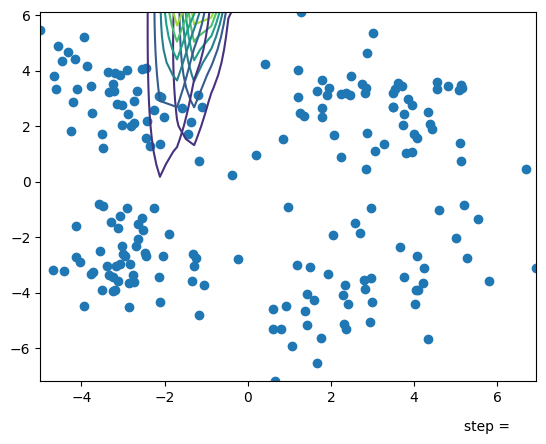

In [70]:
# if the code is robust, we should just have modify the initialisation part.
# Dimensions of the matrices should aftwerwards be carried on.

def init(X):

    # 4 values of same probability
    pi = np.array([0.25, 0.25, 0.25, 0.25])

    # Global mean
    global_mean = X.mean(axis=0)

    # 4 vectors shifted with respect to the global mean
    mu = np.array([
        global_mean + [1, 1],
        global_mean + [-1, 1],
        global_mean + [1, -1],
        global_mean + [-1, -1]
    ])

    # Covariance matrix of all data points, same for all classes
    Sig = np.tile(np.cov(X.T)[np.newaxis, :, :], (4, 1, 1))

    return pi, mu, Sig


pi, mu, Sig = EM(Xg, saveParam="params_gauss/gauss")
create_animation(Xg, "params_gauss", "gauss")


### Trying bad initialisation parameters

* mu = 4 vectors of dimension 2 shifted with respect to the global mean by [4,2], [3,4], [0,0], [-5,0]


Starting from the wrong points does not necessarily leads to the correct estimates
![gauss_bad.gif](attachment:gauss_bad.gif)


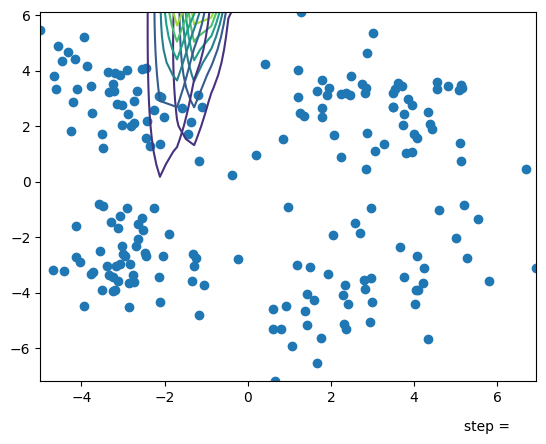

In [71]:
def init(X):

    # 4 values of same probability
    pi = np.array([0.25, 0.25, 0.25, 0.25])

    # Global mean
    global_mean = X.mean(axis=0)

    # 4 vectors shifted with respect to the global mean
    mu = np.array([
        global_mean + [4, 2],
        global_mean + [3, 4],
        global_mean + [0, 0],
        global_mean + [-5, 0]
    ])

    # Covariance matrix of all data points, same for all classes
    Sig = np.tile(np.cov(X.T)[np.newaxis, :, :], (4, 1, 1))

    return pi, mu, Sig

pi, mu, Sig = EM(Xg, saveParam="params_gauss_bad/gauss")
create_animation(Xg, "params_gauss_bad", "gauss")

# C- Demonstration of the formulas for the M Step

**Note that the two-dimensional normal formula has been flattened: the two dimensions of the vectors are expressed as $(x,z)$, the means are $\mu_{x},\mu_{z}$ and the variance matrix $\Sigma$ is replaced by the standard deviations on both dimensions and the linear correlation coefficient: $\Sigma = \begin{pmatrix} \sigma_x & \rho \\ \rho & \sigma_z \end{pmatrix}$**.

We assume here that the pairs of duration and waiting time $(x,z)$ follow a mixture of
 two-dimensional normal distributions. The probability distribution
probability distribution that we want to estimate is :

$$P(x,z|\Theta) = \pi_0
\mathcal{N}(\mu_{x0},\mu_{z0},\sigma_{x0},\sigma_{z0},\rho_0) (x,z) + \pi_1
\mathcal{N}(\mu_{x1},\mu_{z1},\sigma_{x1},\sigma_{z1},\rho_1) (x,z)$$

We will note $f(\mu_{x},\mu_{z},\sigma_{x},\sigma_{z},\rho)$ the function
of a two-dimensional normal distribution:

$$ \begin{array}{l}
  f_{\mu_x,\mu_z,\sigma_x,\sigma_z,\rho}(x,z) =
  \frac{1}{2 \pi \sigma_x \sigma_z \sqrt{1-\rho^2}} \\
  \quad\quad\quad\quad
  \exp \left\{ -\frac{1}{2(1-\rho^2)}
    \left[ \left(\frac{x-\mu_x}{\sigma_x} \right)^2
      - 2\rho\frac {(x-\mu_x)(z-\mu_z)}{\sigma_x \sigma_z}
      + \left( \frac {z-\mu_z}{\sigma_z} \right)^2
    \right]
  \right\}.
\end{array}$$

Therefore, the logarithm of this function is:

$$\begin{array}{@{}l@{}}
  \log f_{\mu_x,\mu_z,\sigma_x,\sigma_z,\rho}(x,z) =
  -\log (2\pi) -\log(\sigma_x) -\log(\sigma_z)
  -\frac{1}{2} \log(1-\rho^2) \\
  \quad\quad\quad\quad
  -\frac{1}{2(1-\rho^2)}
  \left[ \left(\frac{x-\mu_x}{\sigma_x} \right)^2
    - 2\rho\frac {(x-\mu_x)(z-\mu_z)}{\sigma_x \sigma_z}
    + \left( \frac {z-\mu_z}{\sigma_z} \right)^2
  \right].
\end{array}$$

The M step will compute:

$\displaystyle\mbox{Argmax}_{\Theta} \log(L^{t+1}(\mathbf{x}^o,\Theta)) =
\mbox{Argmax}_{\Theta} \sum_{i=1}^n \sum_{k=0}^1 Q_i^{t+1}(y_k) \log
\left(\frac{p(x_i,z_i,y_k | \Theta)}{Q_i^{t+1}(y_k)}\right)$

$= \mbox{Argmax}_{\Theta} \sum_{i=1}^n
Q_i^{t+1}(y_0) \log ( \pi_0
f_{\mu_{x0},\mu_{z0},\sigma_{x0},\sigma_{z0},\rho_0} (x,z) ) +
Q_i^{t+1}(y_1) \log ( \pi_1
f_{\mu_{x1},\mu_{z1},\sigma_{x1},\sigma_{z1},\rho_1} (x,z) )$

Given that $\pi_1 = 1 - \pi_0$

$\displaystyle\frac{\partial\log(L^{t+1}(\mathbf{x}^o,\Theta))}{\partial \pi_0}
= \sum_{i=1}^n Q_i^{t+1}(y_0) \frac{1}{\pi_0} -
\sum_{i=1}^n Q_i^{t+1}(y_1) \frac{1}{1 - \pi_0} = 0$

Thus:

$$\pi_0 = \frac{\sum_{i=1}^n Q_i^{t+1}(y_0)}{\sum_{i=1}^n Q_i^{t+1}(y_0) +
  Q_i^{t+1}(y_1)}\quad\quad\quad\quad(1)$$

and

$$\pi_1 = 1 - \pi_0 =
\frac{\sum_{i=1}^n Q_i^{t+1}(y_1)}{\sum_{i=1}^n Q_i^{t+1}(y_0) +
  Q_i^{t+1}(y_1)}\quad\quad\quad\quad(2)$$

Now let's calculate how to update $\mu$:

$\displaystyle\frac{\partial\log(L^{t+1}(\mathbf{x}^o,\Theta))}{\partial\mu_0}=\frac{\partial}{\partial\mu_{x0}}\sum_{i=1}^n Q_i^{t+1}(y_0)\left(-\frac{1}{2(1-\rho_0^2)} \right)\left[\left(\frac{x_i-\mu_{x0}}{\sigma_{x0}}\right)^2-2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}\right]$

$\displaystyle\Longleftrightarrow\sum_{i=1}^n Q_i^{t+1}(y_0)\left(-\frac{1}{2(1-\rho_0^2)}\right)\left[2\left(\frac{x_i-\mu_{x0}}{\sigma_{x0}^2}\right) - 2\rho_0\frac {z_i-\mu_{z0}}{\sigma_{x0} \sigma_{z0}}\right] = 0$

which is equivalent to:

$$\sum_{i=1}^n Q_i^{t+1}(y_0) \left[ 2 \left(\frac{x_i - \mu_{x0}}{\sigma_{x0}} \right) - 2\rho_0\frac {z_i-\mu_{z0}}{\sigma_{z0}} \right] = 0 \quad\quad\quad\quad(3)$$

By symmetry, deriving with respect to {$\mu_{z0}$} we also have:

$$\sum_{i=1}^n Q_i^{t+1}(y_0) \left[ 2 \left(\frac{z_i - \mu_{z1}}{\sigma_{z1}} \right)
  - 2\rho_0\frac {x_i-\mu_{x0}}{\sigma_{x0}} \right] = 0 \quad\quad\quad\quad(4)$$

If we add $\rho_0$ times the equation $(4)$ to the equation $(3)$,
we get :


$$\sum_{i=1}^n Q_i^{t+1}(y_0) \times 2 \left[ \frac{1 - \rho_0^2}{\sigma_{x0}}\right](\mu_{x0} - x_i) = 0$$

which is equivalent to:

$$\mu_{x0} = \frac{\sum_{i=1}^n Q_i^{t+1}(y_0) x_i}{\sum_{i=1}^n Q_i^{t+1}(y_0)}
\quad\quad\quad\quad(5)$$

By symmetry we have:

$$\mu_{z0} = \frac{\sum_{i=1}^n Q_i^{t+1}(y_0) z_i}{\sum_{i=1}^n Q_i^{t+1}(y_0)}
\quad\quad\quad\quad(6)$$

Let us now compute the expressions of $\sigma$ and $\rho$:

$\frac{\partial\log(L^{t+1}(\mathbf{x}^o,\Theta))}{\partial\sigma_{x0}}=\frac{\partial}{\partial\sigma_{x0}}\sum_{i=1}^nQ_i^{t+1}(y_0)\left\{-\log(\sigma_{x0})-\frac{1}{2(1-\rho_0^2)}\left[\left(\frac{x_i-\mu_{x0}}{\sigma_{x0}}\right)^2-2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}\right]\right\}$


$\displaystyle= \sum_{i=1}^n Q_i^{t+1}(y_0)\left\{-\frac{1}{\sigma_{x0}}-\frac{1}{2(1-\rho_0^2)}\left[-2\frac{(x_i-\mu_{x0})^2}{\sigma_{x0}^3}+2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}^2}\right]\right\}=0$

$\displaystyle\Longleftrightarrow \sum_{i=1}^n Q_i^{t+1}(y_0)\left\{-1-\frac{1}{2(1-\rho_0^2)}\left[-2\frac{(x_i-\mu_{x0})^2}{\sigma_{x0}^2}+2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}\right]\right\}=0$

which is equivalent to:

$$2(1-\rho_0^2)\sum_{i=1}^n Q_i^{t+1}(y_0)=\sum_{i=1}^n Q_i^{t+1}(y_0)\left\{\left[2\frac{(x_i-\mu_{x0})^2}{\sigma_{x0}^2}-2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}\right]\right\}\quad\quad\quad\quad(7)$$

By symmetry, when we derive with respect to $\sigma_{z0}$, we get:

$$2(1-\rho_0^2)\sum_{i=1}^n Q_i^{t+1}(y_0)=\sum_{i=1}^n Q_i^{t+1}(y_0)\left\{\left[2\frac{(z_i-\mu_{z0})^2}{\sigma_{z0}^2}-2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}\right]\right\}\quad\quad\quad\quad(8)$$

By adding the 2 equations $(7)$ and $(8)$, we obtain:

$$4(1-\rho_0^2)\sum_{i=1}^nQ_i^{t+1}(y_0)=2\sum_{i=1}^nQ_i^{t+1}(y_0)\left\{\left[\frac{(x_i-\mu_{x0})^2}{\sigma_{x0}^2}-2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}+\frac{(z_i-\mu_{z0})^2}{\sigma_{z0}^2}\right]\right\}\quad\quad\quad\quad(9)$$

Finally, let us derive the log-likelihood with respect to $\rho_0$:

$\begin{array}{l}\displaystyle\frac{\partial\log(L^{t+1}(\mathbf{x}^o,\Theta))}{\partial\rho_{0}}=\frac{\partial}{\partial\rho_{x0}}\sum_{i=1}^n Q_i^{t+1}(y_0)\left\{-\frac{1}{2}\log(1-\rho_0^2)\right.\\\displaystyle\quad\quad\quad\quad-\frac{1}{2(1- \rho_0^2)}\left.\left[\frac{(x_i-\mu_{x0})^2}{\sigma_{x0}^2}-2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}+\frac{(z_i-\mu_{z0})^2}{\sigma_{z0}^2}\right]\right\}\end{array}$

$\begin{array}{l}\displaystyle=\sum_{i=1}^n Q_i^{t+1}(y_0)\left\{\frac{\rho_0}{1-\rho_0^2}\right.\\\displaystyle\quad\quad\quad-\frac{\rho_0}{(1- \rho_0^2)^2}\left[\frac{(x_i-\mu_{x0})^2}{\sigma_{x0}^2}-2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}+\frac{(z_i-\mu_{z0})^2}{\sigma_{z0}^2}\right]\\\displaystyle\quad\quad\quad+\frac{1}{1-\rho_0^2}\left.\left[\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}\right]\right\}=0\end{array}$

$\begin{array}{l}\displaystyle\Longleftrightarrow\sum_{i=1}^n Q_i^{t+1}(y_0)\left\{\rho_0\right.\\\displaystyle\quad\quad\quad-\frac{\rho_0}{(1- \rho_0^2)}\left[\frac{(x_i-\mu_{x0})^2}{\sigma_{x0}^2}-2\rho_0\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}+\frac{(z_i-\mu_{z0})^2}{\sigma_{z0}^2}\right]\\\displaystyle\quad\quad\quad+\left.\left[\frac{(x_i-\mu_{x0})(z_i-\mu_{z0})}{\sigma_{x0}\sigma_{z0}}\right]\right\}=0\end{array}$

Replacing the 2nd term with the left-hand member of equation (9), we obtain :

$\displaystyle\sum_{i=1}^n Q_i^{t+1}(y_0)\left\{\rho_0 - 2 \rho_0+\left[\frac{(x_i - \mu_{x0})(z_i - \mu_{z0})}{\sigma_{x0}\sigma_{z0}}\right]\right\} = 0$

As a result,

$$\displaystyle\rho_0 = \frac{\sum_{i=1}^n Q_i^{t+1}(y_0)\frac{(x_i - \mu_{x0})(z_i - \mu_{z0})}{\sigma_{x0}\sigma_{z0}}}{\sum_{i=1}^n Q_i^{t+1}(y_0)}\quad\quad\quad\quad(10)$$

Let's write $\eta = \sum_{i=1}^n Q_i^{t+1}(y_0)(x_i - \mu_{x0})(z_i - \mu_{z0})$. Then:

$$\displaystyle\rho_0 = \frac{\eta}{\sigma_{x0}\sigma_{z0}\sum_{i=1}^n Q_i^{t+1}(y_0)}$$

Replacing $\rho_0$ by its value in equation (8), we obtain:

$\begin{array}{l}\displaystyle2\left(1-\left(\frac{1}{\sum_{i=1}^n Q_i^{t+1}(y_0)}\right)^2\frac{\eta^2}{\sigma_{x0}^2\sigma_{z0}^2}\right)\sum_{i=1}^n Q_i^{t+1}(y_0)=\\\displaystyle\quad\quad\quad\quad2 \left(\sum_{i=1}^n Q_i^{t+1}(y_0)\frac{(x_i-\mu_{x0})^2}{\sigma_{x0}^2}\right)-2\frac{\eta^2}{\sigma_{x0}^2\sigma_{z0}^2\sum_{i=1}^n Q_i^{t+1}(y_0)}\end{array}$

which is equivalent to:

$\displaystyle \sigma_{x0}^2 \sum_{i=1}^n Q_i^{t+1}(y_0) = \sum_{i=1}^n Q_i^{t+1}(y_0) (x_i-\mu_{x0})^2.$

Thus

$$\displaystyle \sigma_{x0}^2 = \frac{\sum_{i=1}^n Q_i^{t+1}(y_0)(x_i-\mu_{x0})^2}{\sum_{i=1}^n Q_i^{t+1}(y_0)}\quad\quad\quad\quad(11)$$

By symmetry

$$\displaystyle\sigma_{z0}^2 = \frac{\sum_{i=1}^n Q_i^{t+1}(y_0)(z_i-\mu_{z0})^2}{\sum_{i=1}^n Q_i^{t+1}(y_0)}\quad\quad\quad\quad(12)$$


